In [1]:
%matplotlib inline

import os

import numpy as np
import pymbar
from scipy.special import logsumexp

from utils.mbarweights import compute_hrex_log_weight_trajectory, compute_scaled_mbar_weight_trajectories

In [11]:
# Where to save the figures.
DATA_DIR_PATH = os.path.join('..', 'mbar_weights')


## Which time series contains the info we need to compute the correlation times that matter for the estimation of the binding free energies?



Given uncorrelated samples, and assuming we know the sets of MBAR maximum likelihood estimates of the unitless free energies $f_k$ up to an arbitrary additive constant, then the free energy is given by the self-consistent expression

$$f_i = - \mathrm{log} \left( \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K \frac{e^{-u_i(x_{k(n)})}}{p_M(x_{k(n)})} \right) = - \mathrm{log} \left( \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K w_{in} \right) = - \mathrm{log} \left( \overline{w}_i \right)$$

with the mixture distribution

$$p_M(x) = \sum_{k=1}^K \frac{N_k}{N} e^{f_k - u_k(x)}$$

where $N_k$ is the number of independent samples collected at state $k$, $k(n)$ is the thermodynamic state at which the $n$-th sample $x_{k(n)}$was sampled, $N = \sum_k N_k$, and we have defined $w_{in}$ the **MBAR weight** for state $i$ and the $n$-th sample. Assuming the fluctuations of $\overline{w}$ are small over time, which is satisfied in the asymptotic regime, we can use error propagation to obtain the variance of the free energy

$$\sigma^2\left[ f_i \right] \approx \frac{\sigma^2\left[ \overline{w}_i \right]}{\overline{w}^2}$$

$\overline{w}_i$ is the average computed from a time series of random variables subject to a correlation function that depends on the underlying sampling. For an HREX calculation, each iteration of the algorithm provides a set of $K$ weights $w_i$. We then define the random variable $w_{H,in}$ as the average MBAR weight for state i across the samples collected from all replicas at iteration n

$$\overline{w}_i = \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K w_{in} = \frac{1}{N_H} \sum_{n=1}^{N_H} w_{H,in}$$

where $N_H = N / K$ now represents the total number of iterations instead of the total number of samples. The variance of the average MBAR weight is thus controlled by the correlation time of the random variable $w_{H,in}$ as

$$\sigma^2\left[ \overline{w}_i \right] = \frac{\sigma^2\left[w_{H,i}\right]}{N_H} \phi_i$$

where $\phi_i$ is the statistical inefficiency of the time series. In binding free energies, we are interested in $f_0 - f_{-1}$, so looking at $\phi_0$ and $\phi_{-1}$ should be sufficient.



## Doubly self-consistent MBAR analysis

In order to estimate $\phi_i$, we need to know all the $f_k$, but MBAR theory was developed assuming uncorrelated samples, which requires knowing $\phi_i$. This is what we can do

1. Compute $f_k$ using all the data.
2. Estimate the number of equilibration interations and statistical inefficiencies for both time series $w_{H,0}$ and $w_{H,1}$.
3. Take $n_{eq} = \mathrm{max}(n_{eq,0}, n_{eq,-1})$ and $\phi = \mathrm{max}(\phi_0, \phi_1)$.
4. If $n_{eq} \approx 0$ and $\phi \approx 1$ we're done, otherwise discard the equilibration iterations and subsample the data and go back to step 1.

## Analysis of SAMPLing data for CB8-G3-0

Let's try using the SAMPLing data for CB8-G3-0 to see if this works.

In [54]:
# Maximum number of analysis iterations.
max_n_iterations = 8

# Load all the MBAR energies. mbar_energies[k][l][n] is the reduced
# potential sampled at state k and evaluated at state l at iteration n.
mbar_energies = np.load(os.path.join(DATA_DIR_PATH, 'SAMPLing-CB8-G3-0-complex-mbar-energies.npz'))['arr_0']
n_states = mbar_energies.shape[0]
# n_states = 69

# Directory used to store partial results.
cache_dir_path = os.path.join(DATA_DIR_PATH, 'doubly_self_consistent_cache')
os.makedirs(cache_dir_path, exist_ok=True)

# Start iterative algorithm
for iteration in range(max_n_iterations):
    print(f'iteration {iteration}')
    
    # Compute the MBAR free energies with all the data available.
    Deltaf_file_path = os.path.join(cache_dir_path, f'Deltaf-{iteration}.npz')
    if os.path.isfile(Deltaf_file_path):
        npz_file = np.load(Deltaf_file_path)
        Deltaf_ij = npz_file['arr_0']
        dDeltaf_ij = npz_file['arr_1']
    else:
        N_k = np.array([mbar_energies.shape[-1] for _ in range(mbar_energies.shape[0])])
        mbar = pymbar.MBAR(mbar_energies, N_k)
        Deltaf_ij, dDeltaf_ij, _ = mbar.getFreeEnergyDifferences()
        np.savez_compressed(Deltaf_file_path, Deltaf_ij, dDeltaf_ij)

    # Print the difference in free energy.
    Deltaf = Deltaf_ij[0]
    print(f'    DF (before discarding) = {Deltaf[-1]} +- {dDeltaf_ij[0][-1]}')

    # Compute the equilibration time and statistical
    # inefficiency of the bound and decoupled states.
    log_weights_file_path = os.path.join(cache_dir_path, f'log_weights-{iteration}.npz')
    if os.path.isfile(log_weights_file_path):
        mbar_log_weight_trajectories = np.load(log_weights_file_path)['arr_0']
    else:
        mbar_log_weight_trajectories = compute_hrex_log_weight_trajectory(
            mbar_energies, Deltaf, computed_states=[0, n_states-1], verbose=True)
        np.savez_compressed(log_weights_file_path, mbar_log_weight_trajectories)

    # Perform automatic equilibration detection on the MBAR weight time series.
    # The normalized correlation function is invariant under scaling factors.
    equilibration_file_path = os.path.join(cache_dir_path, f'equilibration-{iteration}.npy')
    if os.path.isfile(equilibration_file_path):
        equilibration_data = np.load(equilibration_file_path)
    else:
        mbar_weight_trajectories = compute_scaled_mbar_weight_trajectories(mbar_log_weight_trajectories)
        equilibration_data = np.empty(shape=(len(mbar_weight_trajectories), 3))
        for trajectory_idx, mbar_weight_trajectory in enumerate(mbar_weight_trajectories):
            equilibration_data[trajectory_idx] = pymbar.timeseries.detectEquilibration(mbar_weight_trajectory, fast=False, nskip=1)
        np.save(equilibration_file_path, equilibration_data)

    for state_idx in range(len(equilibration_data)):
        t, g_t, N_eff_max = equilibration_data[state_idx]
        print(f'    state {state_idx}: n_equil_iterations={t}, statistical_ineff={g_t}, n_effective_iter={N_eff_max}')

    # Subsample mbar_energies.
    t_max = max(equilibration_data[:,0])
    g_t_max = max(equilibration_data[:,1])
    uncorrelated_indices = []
    n = 0
    while int(round(n * g_t_max)) < mbar_energies.shape[-1] - t_max:
        t = int(round(n * g_t_max))
        # ensure we don't sample the same point twice
        if (n == 0) or (t != uncorrelated_indices[n - 1]):
            uncorrelated_indices.append(t)
        n += 1
    uncorrelated_indices = np.array(uncorrelated_indices, dtype=np.int) + int(t_max)
    mbar_energies = mbar_energies[:,:,uncorrelated_indices]
    print(f'    {len(uncorrelated_indices)} iterations remaining')

iteration 0
    DF (before discarding) = 145.1359186165197 +- 0.027608100586754204
    state 0: n_equil_iterations=24455.0, statistical_ineff=2.3346922397613525, n_effective_iter=6659.12158203125
    state 1: n_equil_iterations=3.0, statistical_ineff=3.662268877029419, n_effective_iter=10921.91796875
    4245 iterations remaining
iteration 1
    DF (before discarding) = 144.96596753438442 +- 0.08504981497992661
    state 0: n_equil_iterations=171.0, statistical_ineff=1.247282862663269, n_effective_iter=3267.101806640625
    state 1: n_equil_iterations=0.0, statistical_ineff=1.3915156126022339, n_effective_iter=3051.34912109375
    2928 iterations remaining
iteration 2
    DF (before discarding) = 144.9460779192019 +- 0.10240748761912259
    state 0: n_equil_iterations=18.0, statistical_ineff=1.2476251125335693, n_effective_iter=2333.23291015625
    state 1: n_equil_iterations=0.0, statistical_ineff=1.1962698698043823, n_effective_iter=2448.444091796875
    2333 iterations remaining
ite

In 3 iterations, the number of equilibration iterations goes to 0.0 for both time series. The statistical inefficiency goes below 1.5 after the first iteration and remains so, but it never goes to 1.0 for the bound state time series, and it bounces back from 1.0 to 1.37 for the decoupled state. The extra statistical inefficiency could be related to numerical noise. In this case, we could consider having statistical inefficiency < 1.5 as a stopping condition for the recursive analysis.

Also, at the third iteration, the MBAR uncertainty (multiplied by 2) agrees very well with the t-based 95% confidence interval computed in SAMPLing from the 5 replicate calculations, which is 0.2 kcal/mol.

## Compute the uncertainty directly from the weights

Let's compute the uncertainty prediction using directly

$$\sigma^2\left[ f_i \right] = \frac{\sigma^2\left[w_{H,i}\right]}{\overline{w}^2 N_H} \phi_i$$

We use the statistical inefficiency obtained during the third iteration as it was the first one with number of equilibration 0.0 and should be uncorrelated.

In [123]:
# Load the weights and the statistical inefficiency after the analysis has converged.
equilibration_data = np.load(os.path.join(cache_dir_path, f'equilibration-3.npy'))
g_t = equilibration_data[:,1]
mbar_log_weight_trajectories = np.load(os.path.join(cache_dir_path, f'log_weights-3.npz'))['arr_0']
mbar_weight_trajectories = compute_scaled_mbar_weight_trajectories(mbar_log_weight_trajectories)

n_hrex_iterations = len(mbar_log_weight_trajectories)
f_0 = logsumexp(mbar_log_weight_trajectories[0] - np.log(n_hrex_iterations))
f_1 = logsumexp(mbar_log_weight_trajectories[1] - np.log(n_hrex_iterations))

# Correlation variance.
f_vars = np.empty(shape=len(g_t))
for state_idx, mbar_weight_trajectory in enumerate(mbar_weight_trajectories):
    f_vars[state_idx] = np.var(mbar_weight_trajectory, ddof=1) / np.mean(mbar_weight_trajectory)**2 * g_t[state_idx] / len(mbar_weight_trajectory)

print('DF: {} +- {}'.format(f_0 - f_1, np.sqrt(np.sum(f_vars))))


DF: 144.92314672049596 +- 0.012027370408876407


The uncertainty computed from the time series is much smaller than the MBAR one. It might be due to numerical instabilities or missing cross-correlations. It seems weird to me though that the cross correlations would account for an order of magnitude, so there may be an error somewhere.

In [8]:
from matplotlib import pyplot as plt

def f1(s):
    #return np.exp(-s**2/4 - s/np.sqrt(2))
    return -s**2/4 - s/np.sqrt(2)

def f2(s):
    #return np.exp(-s**2/4)
    return -s**2/4

def df1(s):
    #return - (s/2 + 1/np.sqrt(2)) * np.exp(-s**2/4 - s/np.sqrt(2))
    return - (s/2 + 1/np.sqrt(2))

def df2(s):
    #return - s/2 * np.exp(-s**2/4)
    return - s/2

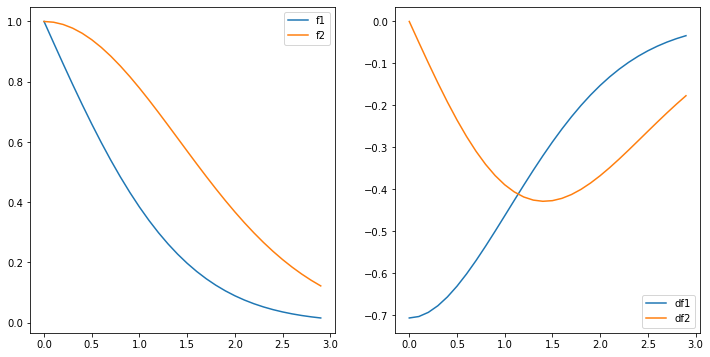

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
x = np.arange(0.0, 3.0, 0.1)

axes[0].plot(x, f1(x), label='f1')
axes[0].plot(x, f2(x), label='f2')
axes[1].plot(x, df1(x), label='df1')
axes[1].plot(x, df2(x), label='df2')

axes[0].legend()
axes[1].legend()

plt.show()

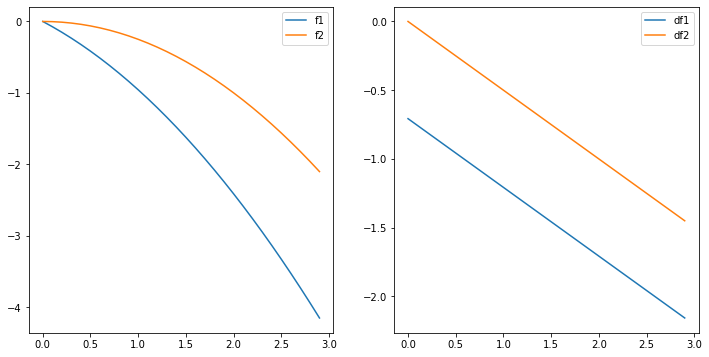

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
x = np.arange(0.0, 3.0, 0.1)

axes[0].plot(x, f1(x), label='f1')
axes[0].plot(x, f2(x), label='f2')
axes[1].plot(x, df1(x), label='df1')
axes[1].plot(x, df2(x), label='df2')

axes[0].legend()
axes[1].legend()

plt.show()

In [10]:
np.log(0.35)

-1.0498221244986778